In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('our-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAGG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGGGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACCGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGT...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 98716.45it/s]


[38, 181, 367, 374, 377, 397, 408, 443, 488, 472, 481, 518, 519, 575, 589, 597, 634, 660, 653, 709, 741, 754, 802, 762, 822, 822, 893, 864, 919, 940, 928, 985, 986, 1009, 1021, 1050, 1066, 1088, 1121, 1168, 1188, 1181, 1182, 1215, 1273, 1266, 1290, 1308, 1314, 1288, 1338, 1324, 1374, 1371, 1973, 1944, 1928, 1913, 1868, 1851, 1857, 1831, 1796, 1790, 1835, 1779, 1703, 1701, 1720, 1664, 1715, 1659, 1644, 1634, 1588, 1557, 1537, 1534, 1534, 1467, 1482, 1473, 1467, 1416, 1447, 1388, 1358, 1363, 1394, 1360, 1318, 1290, 1293, 1251, 1259, 1196, 1201, 1188, 1151, 1147, 1089, 1092, 1085, 1088, 1013, 1005, 1016, 1028, 732, 1579]


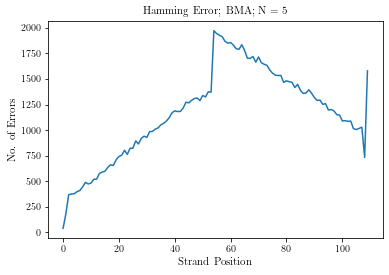

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-our-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:05<00:00, 1957.63it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


GT -> C 6
CTG ->  6
CAG ->  6
TG -> C 6
AT -> C 6
T -> AG 7
G -> CT 7
G -> TT 7
A -> CCC 7
CC ->  7
T -> GC 8
TA -> C 8
G -> CCC 9
T -> GG 9
G -> CA 9
A -> CG 9
 -> ACC 10
T -> CG 10
T -> CCC 11
T -> GA 11
T -> CA 12
AC ->  16
AA ->  16
T -> AC 17
G -> AC 17
CA ->  18
G -> AA 18
GG ->  21
 -> GT 21
GC ->  23
TT ->  24
TC ->  26
CG ->  27
AT ->  28
GA ->  28
 -> CA 28
T -> AA 30
CT ->  30
 -> TG 31
 -> TC 31
 -> AG 31
TA ->  32
AG ->  34
 -> AT 34
 -> GA 36
 -> GC 37
 -> TA 37
 -> GG 38
T -> CC 38
TG ->  39
GT ->  44
 -> AA 44
 -> CT 45
 -> CG 46
 -> TT 46
 -> AC 49
G -> CC 50
A -> CC 52
 -> CC 61
A -> T 110
C -> T 121
C -> A 154
C -> G 182
A -> G 186
G -> T 238
T -> G 384
G -> A 386
G -> C 506
A -> C 548
T -> A 641
T -> C 670
C ->  679
 -> T 721
 -> G 824
 -> A 954
 -> C 1053
A ->  1168
T ->  1316
G ->  1463


G ->  @ 15 6
A -> C @ 109 6
T -> C @ 6 6
 -> C @ 16 6
 -> C @ 14 6
A -> C @ 106 6
T -> C @ 58 6
A -> C @ 17 6
G ->  @ 31 6
G ->  @ 68 6
 -> A @ 36 6
A ->  @ 96 6
G ->  @ 66 6
G ->  @ 47 6
 -> C @ 21 6
A -> C @ 91 6
G ->  @ 18 6
A -> C @ 12 6
 -> TA @ 53 6
G -> A @ 96 6
T -> C @ 43 6
T -> G @ 31 6
A -> C @ 80 6
 -> C @ 38 6
T -> G @ 12 6
A -> C @ 3 6
 -> C @ 11 6
G -> C @ 27 6
G -> A @ 11 6
G -> A @ 55 6
G -> C @ 13 6
G -> A @ 52 6
A -> C @ 49 6
T -> C @ 96 6
G -> A @ 48 6
A ->  @ 98 6
T -> G @ 3 6
A -> C @ 10 6
T -> C @ 9 6
T -> C @ 88 6
G ->  @ 100 6
T -> G @ 107 6
G ->  @ 78 6
A -> C @ 7 6
 -> AT @ 53 6
G -> C @ 4 6
G -> A @ 78 6
G ->  @ 83 6
G -> A @ 77 6
G ->  @ 71 6
G ->  @ 84 6
G ->  @ 86 6
G ->  @ 87 6
T -> C @ 80 6
 -> C @ 33 6
G ->  @ 94 6
G ->  @ 98 6
T -> G @ 74 6
T -> C @ 77 6
 -> C @ 108 6
C ->  @ 41 6
T ->  @ 86 6
T -> A @ 73 6
T ->  @ 7 6
A ->  @ 12 6
T ->  @ 68 6
T -> A @ 78 6
A ->  @ 40 6
A ->  @ 42 6
A ->  @ 43 6
A ->  @ 44 6
T -> A @ 93 6
T -> A @ 95 6
 -> C @ 98 6
A

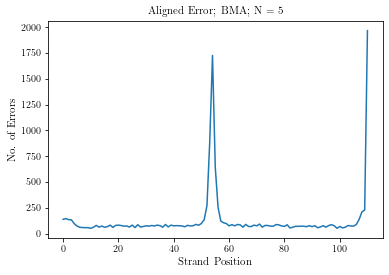

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-our-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 4, 3, 8, 7, 10, 2, 7, 2, 9, 4, 8, 7, 4, 7, 6, 9, 4, 6, 7, 8, 7, 9, 7, 8, 8, 4, 12, 7, 2, 1, 6, 12, 14, 10, 5, 3, 8, 3, 15, 10, 8, 7, 4, 8, 12, 9, 6, 9, 5, 15, 7, 12, 21, 87, 62, 15, 8, 13, 9, 9, 8, 3, 8, 10, 4, 6, 9, 6, 2, 5, 6, 4, 4, 7, 10, 11, 11, 6, 5, 7, 8, 5, 6, 6, 5, 6, 6, 11, 8, 11, 9, 8, 2, 6, 9, 3, 13, 6, 5, 6, 4, 9, 10, 12, 5, 7, 18, 41, 37, 450]
[0, 15, 19, 25, 10, 7, 0, 6, 11, 6, 4, 1, 10, 4, 13, 6, 9, 12, 11, 9, 7, 9, 5, 8, 5, 7, 7, 5, 8, 10, 7, 9, 11, 6, 5, 10, 8, 11, 12, 10, 3, 4, 11, 9, 7, 9, 8, 12, 10, 9, 3, 12, 8, 33, 111, 72, 21, 15, 14, 7, 11, 8, 10, 10, 7, 10, 13, 9, 6, 9, 12, 8, 9, 6, 7, 9, 8, 11, 15, 12, 4, 14, 9, 5, 10, 6, 6, 6, 4, 8, 10, 6, 6, 8, 11, 5, 4, 12, 9, 10, 7, 6, 8, 14, 5, 11, 20, 15, 38, 44, 89]
[0, 3, 4, 1, 7, 4, 4, 4, 4, 6, 4, 9, 6, 4, 6, 3, 5, 2, 5, 5, 6, 10, 8, 6, 3, 6, 5, 8, 5, 6, 9, 4, 5, 8, 3, 3, 4, 6, 5, 5, 6, 4, 6, 6, 6, 4, 7, 5, 1, 5, 2, 6, 9, 31, 96, 66, 14, 6, 4, 5, 5, 7, 6, 9, 3, 3, 9, 3, 1, 11, 9, 4, 3, 8, 5, 7, 7, 6, 5, 2, 6, 6, 2,

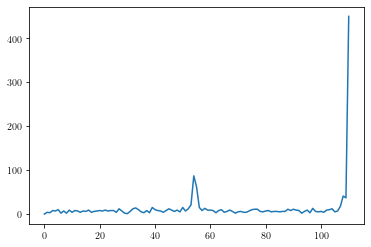

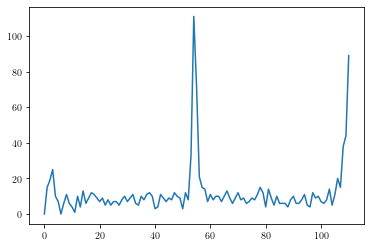

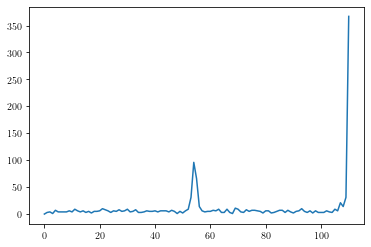

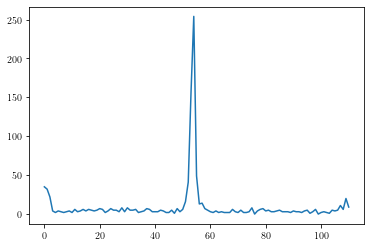

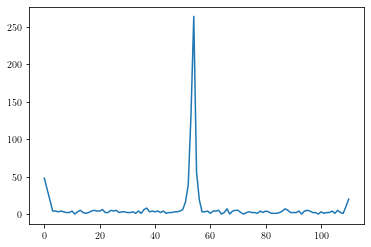

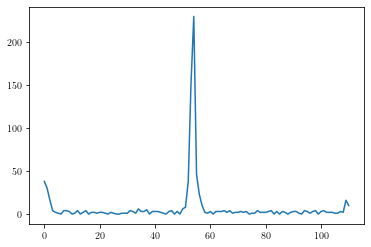

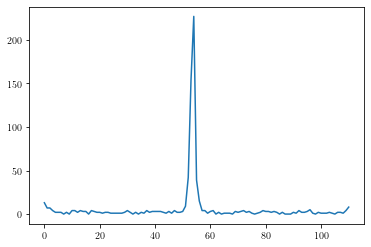

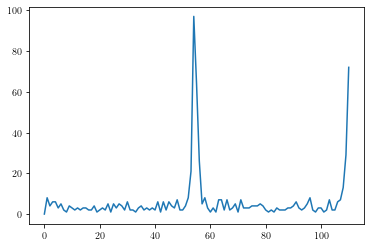

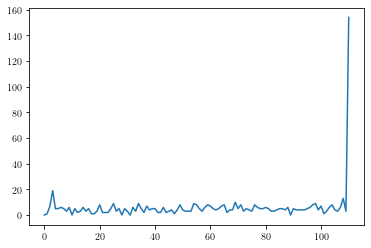

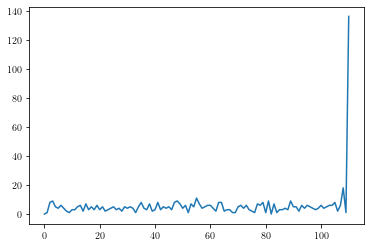

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)